<a href="https://colab.research.google.com/github/JyJumu/k_brazos_LAVC/blob/main/Softmax_EML_bernoulli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos UCB en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Authors: Jesús Verdú Chacón
             Jorge López Abad
    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [ ]:
#@title Copiar el repositorio.

!git clone https://github.com/JyJumu/k_brazos_LAVC.git
!cd k_brazos_LAVC/

Cloning into 'k_brazos_LAVC'...
remote: Enumerating objects: 332, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 332 (delta 76), reused 0 (delta 0), pack-reused 196 (from 1)
Receiving objects: 100% (332/332), 4.61 MiB | 11.73 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
#sys.path.append('/content/EML')
sys.path.append('/content/k_brazos_LAVC/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List
import matplotlib.pyplot as plt

from algorithms import Algorithm, EpsilonGreedy, UCB1, UCB2, Softmax, Gradiente
from arms import ArmNormal, Bandit, ArmBernoulli, ArmBinomial
from plotting import plot_average_rewards, plot_optimal_selections, plot_regret, plot_arm_statistics, plot_arm_num_choices


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_LAVC']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.
    arm_stats = [{'mean_rewards': np.zeros(bandit.k), 'selections': np.zeros(bandit.k)} for _ in algorithms]

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret acumulado.
    optimal_reward = bandit.pull_arm(optimal_arm)

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                arm_stats[idx]['mean_rewards'][chosen_arm] += reward # Actualizar la ganancia del brazo seleccionado por el algoritmo.
                arm_stats[idx]['selections'][chosen_arm] += 1 # Actualizar el número de selecciones del brazo seleccionado por el algoritmo.
                if isinstance(algo, Gradiente):
                    algo.update(chosen_arm, reward, step) # Actualizar el valor estimado del brazo seleccionado.
                else:
                    algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.
                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # Modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                #regret_accumulated[idx, step] = step*optimal_reward - total_rewards_per_algo[idx]
                regret_accumulated[idx, step] = regret_accumulated[idx, step-1] + (optimal_reward - reward) if step > 0 else optimal_reward - reward

    rewards /= runs

    # Calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100
    regret_accumulated /= runs
    for stat in arm_stats:
        stat['mean_rewards'] /= runs
        stat['selections'] /= runs

    return rewards, optimal_selections, regret_accumulated, arm_stats


## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 4 algoritmos Softmax: dos de tipo Softmax y otros dos de tipo gradiente de preferencias.

A diferencia de los algoritmos ε-Greedy, donde se selecciona a los algoritmos de manera aleatoria con probabilidad ε y, en el resto de casos, se selecciona al brazo con mayor recompensa promedio; en los algoritmos Softmax se calcula una probabilidad de selección para cada una de las acciones y se termina eligiendo una de ellas de acuerdo con la distribución de probabilidad resultante.

En este notebook y en los otros que utilizamos este tipo de algoritmos tomamos valores τ = 0.1 y τ = 1 para softmax y α = 0.1 y α = 0.4 para el gradiente de preferencias.

Asimismo, la distribución de los brazos del bandido es de tipo bernoulli. Esto significa que los brazos del bandido solo puede dar dos resultados: acierto -valor 1- o fracaso -valor 0-. El resultado obtenido depende de una cierta probabilidad p.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definimos un algoritmo UCB
algorithms = [Softmax(k=k, tau=0.1), Softmax(k=k, tau=1), Gradiente(k=k, alfa=0.1), Gradiente(k=k, alfa=0.4)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.37), ArmBernoulli(p=0.95), ArmBernoulli(p=0.6), ArmBernoulli(p=0.73), ArmBernoulli(p=0.16), ArmBernoulli(p=0.06), ArmBernoulli(p=0.87), ArmBernoulli(p=0.71), ArmBernoulli(p=0.97), ArmBernoulli(p=0.02)
Optimal arm: 9 with expected reward=0.97


## Visualización de los resultados

### Recompensa promedio vs pasos de tiempo

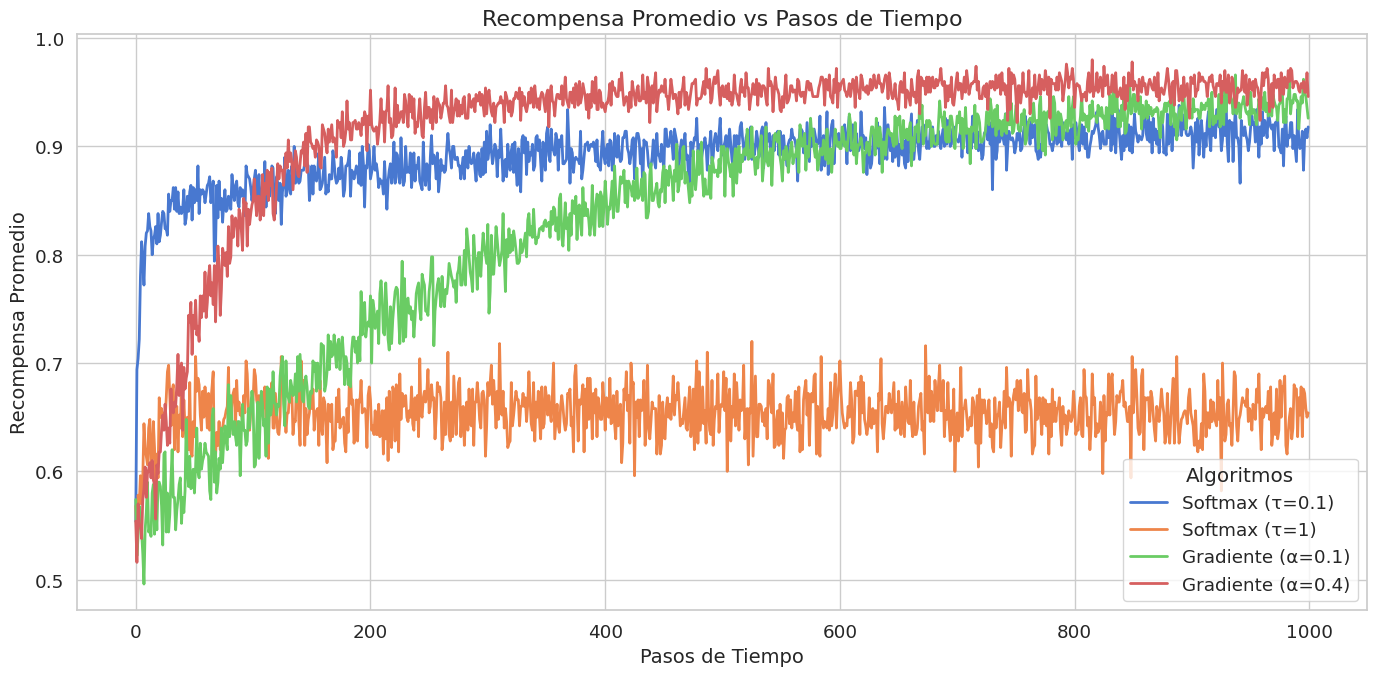

In [ ]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias de los algoritmos **softmax** y **gradiente de preferencias** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **En las tres primeras gráficas de esta sección, las cuatro líneas de colores distintos representan diferentes valores de α y τ en los algoritmos de la familia softmax:**
   - **Azul (softmax con τ=0.1):** Cuanto menor sea el valor de τ, más se favorecen las acciones con mayor estimación de recompensa. Es por ello que en este caso nos encontramos con una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (softmax con τ=1):** Representa una estrategia en la cual las probabilidades se distribuyen más uniformemente, tendiendo a ser más exploradora.
   - **Verde (gradiente de preferencias con α = 0.1):** El parámetro α representa la tasa de aprendizaje con la que se actualizan las preferencias de las acciones. Cuanto menor sea el valor, más lentamente se actualizarán las preferencias. Es por ello que en este caso nos encontramos con una estrategia más exploradora, pues explora antes de converger.
   - **Rojo (gradiente de preferencias con α = 0.4):** Representa una estrategia en la que la tasa de aprendizaje es mayor, por lo que se le da más peso a las recompensas recientes, redundando en una estrategia más explotadora.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (gradiente de preferencias con α = 0.1)** tiene un crecimiento lento pero constante, llegando a alcanzar una recompensa promedio de más de 0.9 al llegar al paso de tiempo mil.
   - La línea **roja (gradiente de preferencias con α = 0.4)** presenta unc recimiento mayor que la línea verde, estancándose en los doscientos pasos en una recompensa promedio de más de 0.9 y superior a la alcanzada por el otro parámetro α.
   - La línea **naranja (softmax con τ=1)** presenta un crecimiento inicial mayor que la línea roja. Sin embargo, se estanca muy pronto en una recompensa promedio no superior a 0.7.
   - La línea **azul (softmax con τ=0.1)** presenta el mayor crecimiento de todos. Converge con la misma rapidez que la línea naranja y no logra una recompensa promedio final superior a las obtenidas con gradiente de preferencias.

---





### Porcentaje de selección del brazo óptimo vs pasos de tiempo

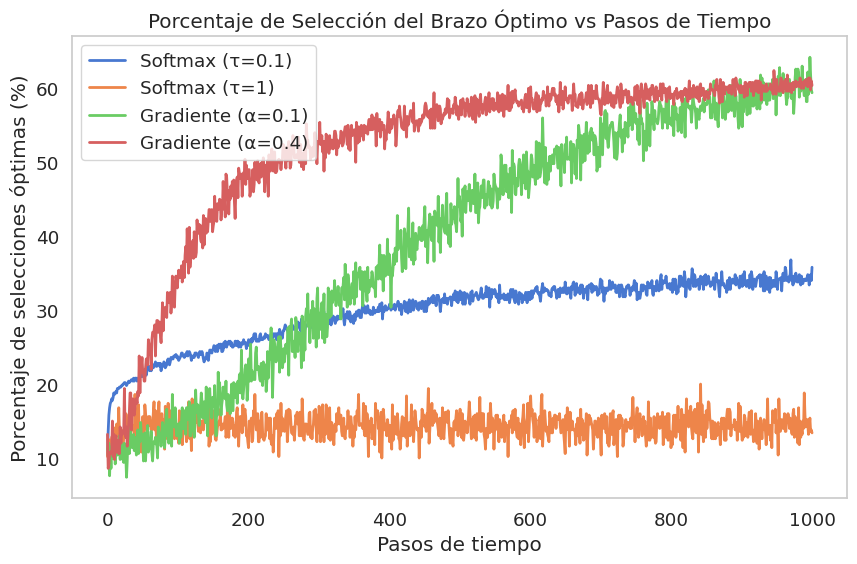

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Porcentaje de Selección del Brazo Óptimo vs Pasos de Tiempo"**. Al igual que en la imagen anterior y en las venideras, en la gráfica se analiza el desempeño de diferentes estrategias de los dos algoritmos de la familia **softmax** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestran es este caso el porcentaje promedio de selección del brazo óptimo la **recompensa promedio** obtenida por cada algoritmo.

* **Crecimiento del porcentaje de selección del brazo óptimo:**
   - La línea **verde (gradiente con α=0.1)** presenta un crecimiento muy lento pero constante, terminando con el mayor procentaje de selecciones óptimas de entre todos los modelos vistos en este notebook.
   - La línea **roja (gradiente con α=0.4)** muestra un gran crecimiento y logra el mayor porcentaje de selecciones óptimas hasta verse superado al llegar a los últimos pasos de tiempo por la línea verde.
   - La línea **naranja (softmax con τ=1)** presenta un crecimiento prácticamente nulo. Se estanca prácticamente al empezar en un porcentaje de selecciones óptimas entre el diez y el veinte porciento.
   - La línea **azul (softmax con τ=0.1)** muestra el mayor crecimiento inicial. Poco después de comenzar, este crecimiento se reduce notablemente. En los últimos pasos de tiempo sigue creciendo, pero apenas ha llegado a un porcentaje de selecciones óptimas promedio de poco más del treinta porciento.
---





### Arrepentimiento acumulado vs pasos de tiempo

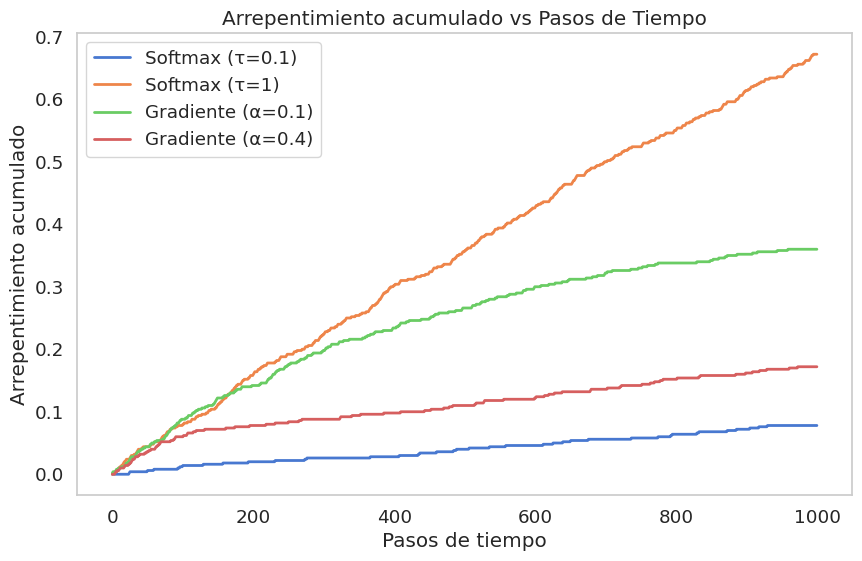

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra un gráfico de líneas titulado **"Arrepentimiento acumulado vs Pasos de Tiempo"**. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el arrepentimiento acumulado de cada algoritmo.

* **Crecimiento del arrepentimiento acumulado:**
   - La línea **verde (gradiente de preferencias con α=0.1)** presenta un crecimiento inicial elevado. En torno a los doscientos pasos este crecimiento se reduce y se termina estancando alrededor de 0.3.
   - La línea **roja (gradiente de preferencias con α=0.4)** presenta un crecimiento inferior a la línea verde y se estanca en poco más de 0.1.
   - La línea **naranja (softmax con τ=1)** presenta el mayor crecimiento de todas y no se reduce a lo largo del tiempo, llegando hasta un 0.7 de arrepentimiento acumulado.
   - La línea **azul (softmax con τ=0.1)** es la que menor crecimiento presenta de todas. Se estanca antes de llegar a un arrepentimiento acumulado de 0.1.

---





### Porcentaje de selección del brazo óptimo vs pasos de tiempo

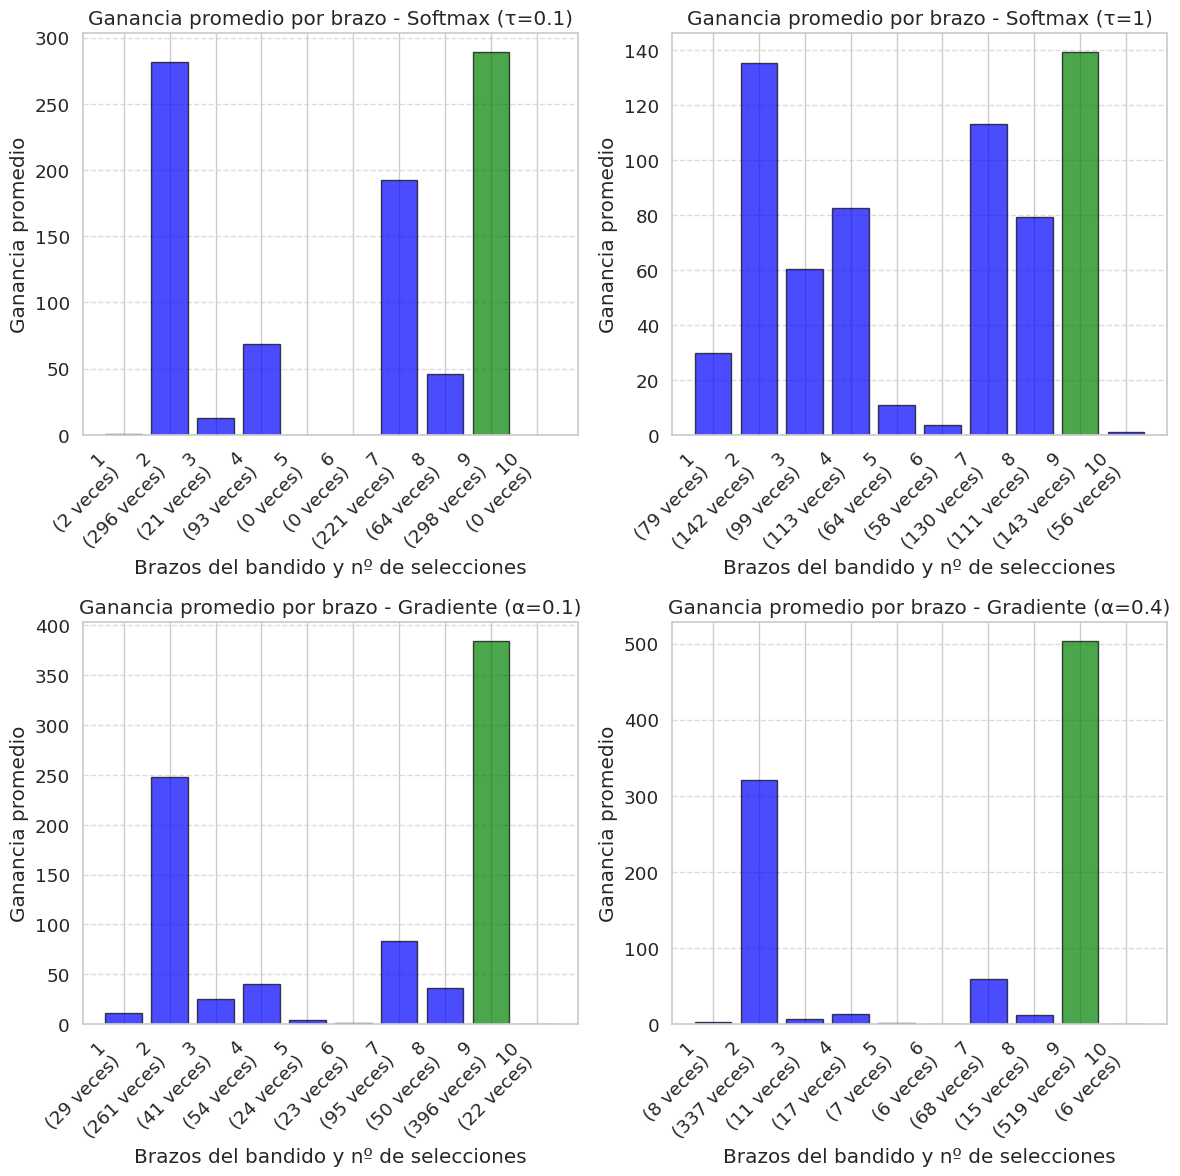

In [ ]:
plot_arm_statistics(arm_stats, algorithms, k, optimal_arm)

**ANÁLISIS DETALLADO DE LA IMAGEN**

La imagen muestra tres gráficos de barras, cada uno titulado **"Ganancia promedio por brazo"**. En el eje **x** se representan los **brazos del bandido**, indicando en paréntesis el número de selecciones por brazo; mientras que en el eje **y** se muestra la ganancia obtenida de cada brazo. Además, la barra del brazo óptimo se muestra en verde y la del resto de brazos en azul.

1. **Las cuatro gráficas que se muestran se corresponden a diferentes valores de τ en el algoritmo softmax y de α en el algoritmo gradiente de preferencias. De izquierda a derecha y de arriba a abajo tenemos:**
   - **Primera gráfica (softmax con τ=0.1):** Representa los resultados de la estrategia completamente **explotadora** para el algoritmo softmax.
   - **Segunda gráfica (softmax con τ=0.01):** Representa una estrategia más explordora del algoritmo softmax.
   - **Tercera gráfica (gradiente con α=0.1):** Representa una estrategia exploradora del algoritmo gradiente de preferencias.
   - **Cuarta gráfica (gradiente con α=0.4):** Representa una estrategia explotadora del algoritmo gradiente de preferencias.

2. **Ganancia y número de selecciones promedio por brazo:**
   - La **primera gráfica (softmax con τ=0.1)** se corresponde con la estrategia más explotadora de softmax. Podemos observar que se seleccionan mayoritariamente el brazo óptimo y el brazo segundo, el cual es el segundo brazo con mayor valor p. El séptimo brazo lo selecciona también en numerosas ocasiones, siendo este el brazo con el tercer mayor valor p.
   - La **segunda gráfica (softmax con τ=1)** muestra que el algoritmo es capaz de seleccionar mayoritariamente el brazo óptimo, aunque yerra en numerosas ocasiones, dando lugar a que otros brazos sean elegidos un número de veces similar aunque menor. La ganancia obtenida es menor que para el otro modelo softmax.
   - La **tercera gráfica (gradiente con α=0.1)** muestra que se consigue seleccionar el brazo óptimo en la amplia mayoría de las ocasiones, aunque yerra muchas veces eligiendo otros brazos, en particular el segundo (que además se corresponde con el que tiene el segundo mayor valor de p).
   - La **cuarta gráfica (gradiente con α=0.1)** muestra un rendimiento mejor que para el otro valor de α, pues la ganancia es mayor y el número de selecciones del brazo óptimo también es mayor. Es de notar que el número de selecciones del segundo brazo también crece y la diferencia entre las selecciones de este brazo y el óptimo es similar a la vista en la gráfica anterior.

---





## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **softmax** equilibra la exploración y la explotación:
- **Explotación (τ<1)**: Favorece más las acciones con mayor recompensa estimada.
- **Exploración (τ>1)**: Distribuye las probabilidades más uniformemente.

Por otro lado, el algoritmo **gradiente de preferencias** también equilibra la exploración y la explotación:
- **Explotación (valores altos de α)**: Las recompensas recientes tienen mayor peso, por lo que las acciones con mayor recompensa se favorecen rápidamente, dando lugar a que el algoritmo converja rápido a una estrategia y que sea pueda estancar en un
máximo local.
- **Exploración (valores bajos de α)**: Las preferencias se actualizan más lentamente, lo que redunda en que se da más oportunidad a todas las acciones antes de decidir una estrategia clara.

Los gráficos de línea y de barras confirman este comportamiento:
- **Gradiente con α=0.1 (verde en los gráficos de línea y el tercero en los de barras)**: El retardo en la actualización de las preferencias hace que tarde más tiempo en encontrar el brazo óptimo. Ello redunda en que el otro valor de α obtenga un mejor rendimiento debido a dicho retraso. Sin embargo, hemos de notar que cuando llegamos a los últimos pasos de tiempo, el rendimiento ofrecido por este valor de α es mejor que usando α=0.4. Además, este modelo ofrece un mejor rendimiento que softmax.
- **Gradiente con α=0.4 (rojo en los gráficos de línea y el último en los de barras)**: Logra encontrar el brazo óptimo más rápido y ello le permite obtener el mejor rendimiento de todos los algoritmos.
- **Softmax con τ=1 (naranja en los gráficos de línea y el segundo en los de barras)**: En este caso, la exploración hace que no termine de elegir una política clara, por lo que va cambiando constantemente de brazo, eligiendo brazos con bajos valores de p y obteniendo, por ende, un arrepentimiento elevado. La ganancia que consigue es la más baja de todos los modelos.
- **Softmax con τ=0.1 (azul en los gráficos de línea y el primero en los de barras)**: Pese a elegir muy pocas veces el brazo óptimo, logra centrarse en los tres brazos con los valores p más altos, por lo que consigue obtener una buena ganancia y un arrepentimiento bajo. Aún así, el rendimiento ofrecido no mejora al obtenido con gradiente de preferencias.

#### **2. Convergencia de los algoritmos**
Si comparamos el rendimiento obtenido entre los valores explotadores y exploradores de cada algoritmo notamos que los valores explotadores ofrecen un mejor rendimiento que los exploradores. Esto se debe a que en este notebook estamos trabajando con brazos con distribución de bernouilli, por lo que, al ser la ganancia binaria (solo podemos tener como ganancia los valores 0 y 1), una buena recompensa en un brazo implica que, en caso de tener una estrategia explotadora, ese brazo sea elegido varias veces en las selecciones venideras, y
en caso de que ese brazo tenga un valor bajo de p, el modelo rápidamente se dará cuenta de que no es una buena elección y lo abandonará.

Por otro lado, una estrategia exploradora implica que se van a intentar elegir todos los brazos, resultando en cada una de las elecciones de un brazo con valor de p bajo, penaliza más que usando una distribución normal. Asimismo, un acierto en un brazo con un bajo valor de p también redunda en que se elija varias veces más en el futuro, resultando en un mayor número de penalizaciones.

#### **3. Aplicaciones y conclusiones**
A diferencia de la distribución normal, en este caso una estrategia explotadora ofrece un mejor rendimiento debido a la enorme penalización que supone obtener un fallo.

De igual manera, el rendimiento conseguido con el **gradiente de preferencias** sigue siendo mayor que el logrado con **softmax**. Siendo la diferencia bastante grande en este caso.

En conclusión, **los gráficos muestran cómo una estrategia de explotación ofrece un mejor rendimiento que una estrategia de exploración**. Además, el **gradiente de preferencias** vuelve a ofrecer un mejor rendimiento que **softmax**. 🚀